In [1]:
#from UNET import Unet
from model import UNet

In [2]:
import torch
import glob
import cv2
import numpy as np
import torch.utils.data as data
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [6]:
#CuDnn radnom제어
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
random_seed =106

#numpy random seed제어
np.random.seed(random_seed)

#torch random seed 제어   -- random split
torch.manual_seed(random_seed)

## Train configure

In [ ]:
batch_size = 2
epochs = 100
learning_rate=1e-5

## Model

In [8]:
in_dim =3
out_dim =1 #### 0 or 1
num_filter = 64

In [9]:
model = UNet.Unet(in_dim, out_dim, num_filter).to(device)

In [23]:
import torchsummary
torchsummary.summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]           1,792
       BatchNorm2d-2         [-1, 64, 254, 254]             128
         LeakyReLU-3         [-1, 64, 254, 254]               0
            Conv2d-4         [-1, 64, 252, 252]          36,928
       BatchNorm2d-5         [-1, 64, 252, 252]             128
         LeakyReLU-6         [-1, 64, 252, 252]               0
         MaxPool2d-7         [-1, 64, 126, 126]               0
            Conv2d-8        [-1, 128, 124, 124]          73,856
       BatchNorm2d-9        [-1, 128, 124, 124]             256
        LeakyReLU-10        [-1, 128, 124, 124]               0
           Conv2d-11        [-1, 128, 122, 122]         147,584
      BatchNorm2d-12        [-1, 128, 122, 122]             256
        LeakyReLU-13        [-1, 128, 122, 122]               0
        MaxPool2d-14          [-1, 128,

# Train

## data load

In [11]:
ROOT_PATH = 'kaggle_3m/'

mask_file = glob.glob(ROOT_PATH + '**/*mask*', recursive=True)   #3차원
image_file = [i.replace('_mask','') for i in mask_file]
total_data_num = len(mask_file)

In [12]:
class brain_dataset(data.Dataset):
    def __init__(self, mask_file, image_file):
        super(brain_dataset, self).__init__()
        self.mask = mask_file
        self.image = image_file
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = idx.tolist()
        mask = mask_file[index]
        image = image_file[index]
        data = cv2.imread(image)
        data = data/255.
        data = data.transpose(2,0,1)
        label = cv2.imread(mask,0)
        
        label = np.expand_dims(label, axis=-1)
        label = label/255.
        label = label.transpose(2,0,1)
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()
    
    def __len__(self):
        return len(self.image)

In [21]:
def create_dataloader(test_ratio=0.2, val_ratio=0.2, batch_size = batch_size):
    r1, r2 = test_ratio, val_ratio
    
    dataset = brain_dataset(mask_file, image_file)
    all_dataset = len(dataset)
    test_dataset = int(all_dataset*r1)
    val_dataset = int((all_dataset-test_dataset)*r2)
    train_dataset = all_dataset - test_dataset - val_dataset
    
    _, test_set = random_split(dataset, [val_dataset+train_dataset, test_dataset])
    train_set, val_set = random_split(_, [train_dataset, val_dataset])
    
    train_loader = torch.utils.data.DataLoader(train_set,
                                         batch_size = batch_size, 
                                         shuffle = True,
                                         drop_last = True)
    val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size = batch_size, 
                                         shuffle = True,
                                         drop_last = True)
    test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size = 1, 
                                         shuffle = True,
                                         drop_last = True)
    return train_loader, val_loader, test_loader
    
    

In [22]:
data_loader, val_loader, test_loader = create_dataloader()

## loss

In [19]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

## Train

In [21]:
citerion = torch.nn.BCELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

In [21]:
################  mask= 1*256*256 0 or 1 
################  output= 1*256*256 sigmoid 0~1
# 왜 CE 안되고 BCE...? ..> CE : sigmoid포함, BCE : sigmoid 포함 x

In [27]:
from tqdm import tqdm

In [ ]:
test_epoch_loss =[]
val_epoch_loss = []
for epoch in range(epochs):
    test_loss =[]
    val_loss = []
    
    model.train()
    for batch_idx, (X,y) in tqdm(enumerate(data_loader)):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        output = torch.sigmoid(output)   ######UNet.py에 추가..???
        pred =torch.nn.functional.interpolate( output, (256,256), mode = 'bilinear', align_corners= True)
        optimizer.zero_grad()
        cost = citerion(pred, y)
        cost.backward()
        optimizer.step()
        
        test_loss += [cost.item()]
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (X,y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)
            output=model(X)
            output = torch.sigmoid(output)
            pred =torch.nn.functional.interpolate( output, (256,256), mode = 'bilinear', align_corners= True)
            
            cost = citerion(pred, y)
            val_loss += [cost.item()]
    
    print("epoch : {}  | test_loss : {} | val_loss : {}".format(epoch, np.mean(test_loss), np.mean(val_loss)))
    test_epoch_loss.append(np.mean(test_loss))
    val_epoch_loss.append(np.mean(val_loss))
          

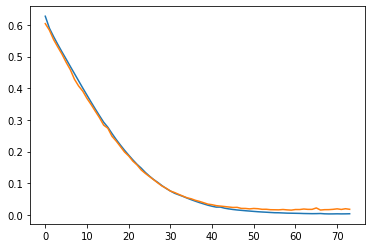

In [33]:
plt.plot(test_epoch_loss)
plt.plot(val_epoch_loss)

In [ ]:
##1257번쩨
##lerning rate schedular : 처음에 높게하기........ 
##아니면 optimizer 다른걸루,, Adam..?????/

## Save model

In [27]:
# 모델의 state_dict 출력
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [35]:
import os
PATH = os.getcwd()
#|}torch.save(model.state_dict(), PATH+'\\'+'Unet_st.pt')

In [39]:
print(PATH)

C:\Users\seungeun\PycharmProjects\pytorch


In [46]:
model

Unet(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [66]:
#torch.save(model, PATH+'\\saved_model\\'+'Unet_model_CE')

##  Test loss

In [5]:
model = torch.load('saved_model\\Unet_model_CE.pt')
citerion = torch.nn.BCELoss(reduction='mean').to(device)

In [22]:
from tqdm import tqdm
with torch.no_grad():
    model.eval()
    test_loss = []
        
    for (X,y) in tqdm(test_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        output = torch.sigmoid(output) 
        pred =torch.nn.functional.interpolate( output, (256,256), mode = 'bilinear', align_corners= True)
        cost = citerion(pred, y)
        test_loss += [cost.item()]
    print('=')
        
        

100%|██████████| 786/786 [00:24<00:00, 32.26it/s]

=


In [57]:
np.mean(test_loss)

0.007501941500427871

## Test image

In [25]:
X,Y = train_set[1]

In [44]:
def test(n):
    X,y = train_set[n]
    X_ = X.to(device)
    X_ = X_.unsqueeze(0)
    output_ = model(X_) # 1, 3, 256,256 -> 1,1,83,83
    output_ =torch.nn.functional.interpolate( output_, (256,256), mode = 'bilinear', align_corners= True) # -> 1,1,256,256
    output = output_.squeeze(0)
    output = output.cpu().detach()
    #output = np.round(output)

    return X, output, y

def show(n):
    X, pred, y = test(n)
    plt.subplot(1, 3, 1)
    plt.imshow(X.numpy().transpose(1,2,0))
    plt.title('image')
    plt.subplot(1, 3, 2)
    plt.imshow(pred.numpy().transpose(1,2,0))
    plt.title('pred')
    plt.subplot(1, 3, 3)
    plt.imshow(y.numpy().transpose(1,2,0))
    plt.title('mask')
    plt.show()

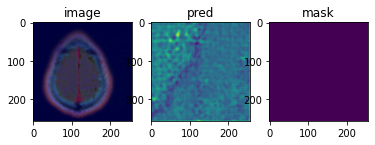

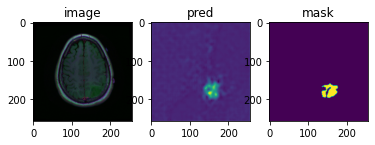

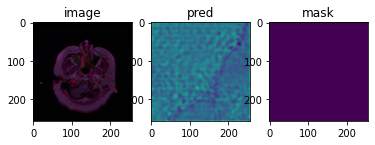

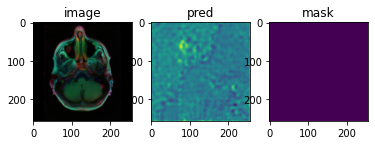

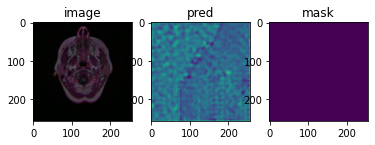

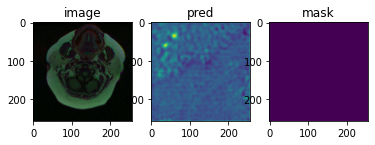

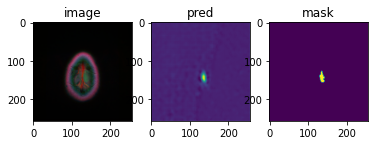

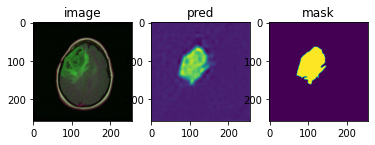

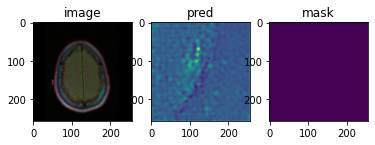

In [54]:
import random

for i in  random.sample(range(0,len(train_set)),10):
    show(i)
    

## Pytorch model

In [18]:
import torch
p_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)

Using cache found in C:\Users\seungeun/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [21]:
citerion = torch.nn.MSELoss().to(device)

In [22]:
with torch.no_grad():
    p_model.eval()
    test_loss = []
    for (X,y) in test_loader:
        X = X.to(device)
        y = y.to(device)
        output = p_model(X)
        pred =torch.nn.functional.interpolate( output, (256,256), mode = 'bilinear', align_corners= True)
        cost = citerion(pred, y)
        test_loss += [cost.item()]
    print('=')
        
        

=


In [24]:
model = p_model

In [25]:
def test(n):
    X,y = train_set[n]
    X_ = X.to(device)
    X_ = X_.unsqueeze(0)
    output_ = model(X_) # 1, 3, 256,256 -> 1,1,80,83
    output_ =torch.nn.functional.interpolate( output_, (256,256), mode = 'bilinear', align_corners= True) # -> 1,1,256,256
    output = output_.squeeze(0)
    output = output.cpu().detach()
    return X, output, y

def show(n):
    X, pred, y = test(n)
    plt.subplot(1, 3, 1)
    plt.imshow(X.numpy().transpose(1,2,0))
    plt.title('image')
    plt.subplot(1, 3, 2)
    plt.imshow(pred.numpy().transpose(1,2,0))
    plt.title('pred')
    plt.subplot(1, 3, 3)
    plt.imshow(y.numpy().transpose(1,2,0))
    plt.title('mask')
    plt.show()

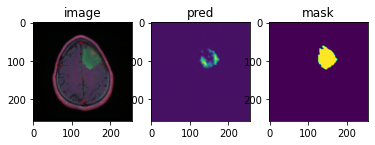

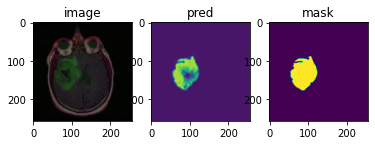

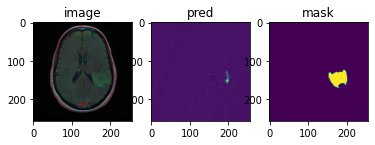

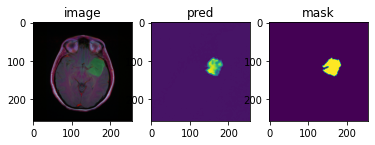

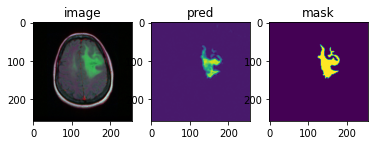

In [57]:
import random

for i in  random.sample(range(1,len(train_set)),5):
    show(i)
    

In [51]:
np.mean(test_loss)

0.009497566742325783